# Задание

1) Натренировать нейронную сеть, отличающую классы bicycle, motorcycle, background (всё, что не велосипед и не мотоцикл). (6 баллов)
    * Можно использовать претренированную модель, но нужно ее дообучить.
    * Не должно быть багов (обратите внимание на дисбаланс классов).
2) Провести анализ результатов (confusion матрица, зависимость точности от внешних условий, сравнение моделей, анализ метрик, ...). (1-2 балла в зависимости от полноты анализа)
3) Сравнить производительность в разных рантаймах: onnxruntime, tensorrt, tvm, tflite, pytorch-keras, openvino... (0.5 балла за каждый фреймворк)
4) Продемонстрировать манипуляцию весами: трансформировать первый слой, чтобы количество входных каналов в первой свертке было не 3, а 1 с минимальной потерей точности. То есть, сетка должна работать на грейскейле. (1 балл)

## Настройки/Гиперпараметры/Импорты

In [34]:
import torchvision # для работы (скачивания, преобразования...) с картинками (датасетом)
import matplotlib.pyplot as plt # для вывода графиков/картинок

import torch # для работы с тензорами и моделями

In [59]:
dtype = torch.float64

# Подготовка датасета и модели

## Датасет

CIFAR-100 — датасет, состоящий из 60 000 изображений, поделенных на 100 классов. В обучающей выборке присутствуют 50 000 изображений, по 500 сэмплов для каждого класса. Тогда как в тестовой — 10 000 по 100 сэмплов.

Каждое изображение имеет размерность (3, 32, 32) ~ (Channels, Height, Width).

Классы (labels) датасета:


In [56]:
classes = ["apple",  "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"]
for i in range (len(classes)):
    print(f"Класс {i}: {classes[i]}")

Класс 0: apple
Класс 1: aquarium_fish
Класс 2: baby
Класс 3: bear
Класс 4: beaver
Класс 5: bed
Класс 6: bee
Класс 7: beetle
Класс 8: bicycle
Класс 9: bottle
Класс 10: bowl
Класс 11: boy
Класс 12: bridge
Класс 13: bus
Класс 14: butterfly
Класс 15: camel
Класс 16: can
Класс 17: castle
Класс 18: caterpillar
Класс 19: cattle
Класс 20: chair
Класс 21: chimpanzee
Класс 22: clock
Класс 23: cloud
Класс 24: cockroach
Класс 25: couch
Класс 26: crab
Класс 27: crocodile
Класс 28: cup
Класс 29: dinosaur
Класс 30: dolphin
Класс 31: elephant
Класс 32: flatfish
Класс 33: forest
Класс 34: fox
Класс 35: girl
Класс 36: hamster
Класс 37: house
Класс 38: kangaroo
Класс 39: keyboard
Класс 40: lamp
Класс 41: lawn_mower
Класс 42: leopard
Класс 43: lion
Класс 44: lizard
Класс 45: lobster
Класс 46: man
Класс 47: maple_tree
Класс 48: motorcycle
Класс 49: mountain
Класс 50: mouse
Класс 51: mushroom
Класс 52: oak_tree
Класс 53: orange
Класс 54: orchid
Класс 55: otter
Класс 56: palm_tree
Класс 57: pear
Класс 58: pi

**Нужные нам классы находятся под индексами 8 (bicycle) и 48 (motorcycle), всё остальное будем считать за "background".**

In [100]:
# преобразования над датасетом
transforms = torchvision.transforms.Compose([ # Compose объединяет несколько преобразований вместе, чтобы они выполнялись "последовательно"
                                             torchvision.transforms.ToTensor(), # преобразование PIL изображения (или ndarray формата (Height x Width x Channels)) в tensor (типа float со значениями в области [0.0, 1.0], если такая трансформация поддерживается (см описание ToTensor))
                                             torchvision.transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)) # нормализация каналов (в датасете три канала) к указанным среднему значению и стандартному отклонению (цифры подобраны под датасет)
])

# датасет для обучения
data_train = torchvision.datasets.CIFAR100(root="./data", # путь, откуда брать/куда сохранять датасет
                                           train=True, # скачиание обучающей части датасета
                                           download=True, # скачивать ли датасет, если его нет в root пути
                                        #    transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                          )

# загрузчик данных для обучения
loader_train = torch.utils.data.DataLoader(dataset=data_train, # указание датасета для DataLoader
                                           batch_size=20, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                           num_workers=5, # число используемых ядер процессора для ускорения обработки данных
                                           pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                           )

# аналогично для тестирования
data_test = torchvision.datasets.CIFAR100(root="./data", # путь, откуда брать/куда сохранять датасет
                                          train=False, # скачиание обучающей части датасета
                                          download=True, # скачивать ли датасет, если его нет в root пути
                                        #   transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                         )

loader_test = torch.utils.data.DataLoader(dataset=data_test, # указание датасета для DataLoader
                                          batch_size=20, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                          num_workers=5, # число используемых ядер процессора для ускорения обработки данных
                                          pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                         )

Files already downloaded and verified
Files already downloaded and verified


In [119]:
image = None
for sample, label in data_train:
    if label == 8:
        image = sample

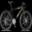

In [120]:
image

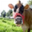

In [103]:
data_train[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


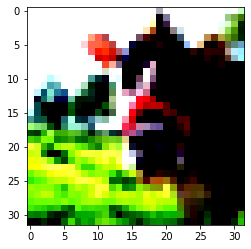

In [55]:
plt.imshow(data_train[0][0].permute(1, 2, 0)) # построение изображения
# .permute(1, 2, 0) меняет местами размерности, на первое место выходит Height, второе — Width, третье — Channels, так как shape(3, 32, 32) ~ (Channels, Height, Width) не воспринимается
# операция схожа с reshape, но permute просто меняет местами индексы, гарантируя, что обращение с соответствующей перестановкой индексов вернёт тот же элемент (что был бы без permute и перестановки индексов)

plt.show() # вывод изображения

## Модель

In [ ]:
# model = timm.create_model("hf_hub:edadaltocg/resnet50_cifar100", pretrained=True) # shape mismatch conv1.weight: copying a param with shape torch.Size([64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 7, 7]).

In [ ]:
# model = timm.create_model("hf_hub:daveni/upside_down_classifier", pretrained=True) # KeyError: 'architecture'

In [122]:
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification, ViTImageProcessor
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

# image = data_train[0][0] # корова

image = None
for sample, label in data_train:
    if label == 8:
        image = sample

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# model = ViTModel.from_pretrained('edumunozsala/vit_base-224-in21k-ft-cifar100')
model = ViTForImageClassification.from_pretrained('edumunozsala/vit_base-224-in21k-ft-cifar100')
inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
# last_hidden_states = outputs.last_hidden_state

In [123]:
torch.argmax(outputs.logits[0])

tensor(8)

# 1) Fine-tuning нейронной сети под задачу

Как вариант решения проблемы дисбаланса классов — увеличим вес нужных классов при подсчёте loss функции, чтобы ошибка в них сильнее отзывалась в модели. Например — увеличим их вес в 20 раз.

In [71]:
loss_weights = torch.ones(size=(100,), dtype=dtype) # вектор с весами для 
loss_weights[8] = 20.0
loss_weights[48] = 20.0
loss_weights

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 20.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1., 20.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.], dtype=torch.float64)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss(weight=loss_weights) # создаём функцию для подсчёта loss с указанием "особых" весов классов
# loss - кросс-энтропия (перекрёстная энтропия)
# CrossEntropyLoss на вход ожидает вероятность класса для всех k классов
# то есть массив с вероятностями для каждой из четырёх категорий новостей

# 2) Анализ результатов

# 3) Сравнение производительности

# 4) Манипуляция с весами